# Exercise 3: Murnaghan plots using sphinx

In [1]:
from pyiron import Project
import numpy as np
import matplotlib.pylab as plt

In [2]:
import pandas as pd
from ast import literal_eval

## Perform a static energy calculation of bulk Al using DFT (Sphinx as open source DFT code)

In [3]:
pr = Project("demo/sphinx_demo")
# pr.remove_jobs()

In [4]:
job_sphinx = pr.create_job(pr.job_type.Sphinx, "test_sphinx")

In [5]:
job_sphinx.structure = pr.create_ase_bulk("Al")

In [6]:
job_sphinx.set_occupancy_smearing(width=0.1)

In [7]:
job_sphinx.plane_wave_cutoff

340

In [8]:
job_sphinx.xc

'PBE'

In [9]:
job_sphinx.set_kpoints(mesh=[5, 5, 5])

### Inspecting the input parameters

In [10]:
job_sphinx.input

Group({'sphinx': Group({'pawPot': Group([]), 'structure': Group([]), 'basis': Group({'kPoint': Group([]), 'folding': array([5, 5, 5])}), 'PAWHamiltonian': Group([]), 'initialGuess': Group([]), 'main': Group([])}), 'EnCut': 340, 'KpointCoords': [0.5, 0.5, 0.5], 'KpointFolding': [5, 5, 5], 'EmptyStates': 'auto', 'Sigma': 0.1, 'Xcorr': 'PBE', 'VaspPot': False, 'Estep': 100, 'Ediff': 0.0001, 'WriteWaves': True, 'KJxc': False, 'SaveMemory': True, 'rhoMixing': 1.0, 'spinMixing': 1.0, 'CheckOverlap': True, 'THREADS': 1})

In [11]:
job_sphinx.calc_static()

In [12]:
job_sphinx.run()

The job test_sphinx was saved and received the ID: 196


In [13]:
job_sphinx.status

'finished'

### Plotting the Fermi-Dirac distribution of the electronic occupancies

In [14]:
job_sphinx["output/generic/dft"]

{'groups': [], 'nodes': ['bands_e_fermi', 'bands_eigen_values', 'bands_k_weights', 'bands_occ', 'computation_time', 'electronic_entropy', 'energy_band', 'energy_free', 'energy_int', 'energy_zero', 'n_valence', 'residue', 'scf_computation_time', 'scf_convergence', 'scf_electronic_entropy', 'scf_energy_band', 'scf_energy_free', 'scf_energy_int', 'scf_energy_zero', 'scf_residue']}

In [15]:
len(job_sphinx["output/generic/dft/scf_energy_int"][-1])

3

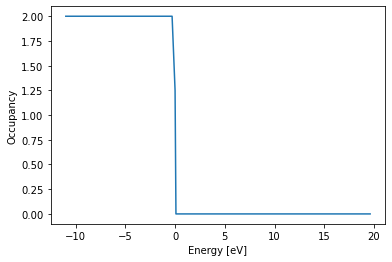

In [16]:
# The first index is the spin (only 1 for non-magnetic calculation)
eigen_values = job_sphinx["output/generic/dft/bands_eigen_values"][-1].flatten()
args = np.argsort(eigen_values)
eigen_values = eigen_values[args]
occ = job_sphinx["output/generic/dft/bands_occ"][0].flatten()[args]
efermi = job_sphinx["output/generic/dft/bands_e_fermi"][-1]
eigen_values -= efermi
plt.plot(eigen_values, occ)
plt.xlabel("Energy [eV]")
plt.ylabel("Occupancy");

### Inspecting the output

In [17]:
job_sphinx["output/generic"]

{'groups': ['dft'], 'nodes': ['cells', 'computation_time', 'energy_pot', 'energy_tot', 'forces', 'positions', 'volume']}

In [18]:
job_sphinx["output/generic/energy_tot"][-1]

-57.19954510906662

## Plotting an E-V curve

In [19]:
pr = Project("demo/murnaghan_Al_dft")
# pr.remove_jobs()

In [20]:
a_range = np.linspace(3.9, 4.2, 6)
encut_list = [350]
kpoint_list = [12]

In [21]:
for kpt in kpoint_list:
    for encut in encut_list:
        for a in a_range:
            job_name = "job_name_a_{:.4}_encut_{}_kpt_{}".format(a, encut, kpt).replace(".", "_")
            print(job_name)
            job = pr.create_job(pr.job_type.Sphinx, job_name)
            job.structure = pr.create_ase_bulk("Al", a=a)
            job.plane_wave_cutoff = encut
            k_mesh = [kpt] * 3
            job.set_kpoints(mesh=k_mesh)
            job.run()

job_name_a_3_9_encut_350_kpt_12
The job job_name_a_3_9_encut_350_kpt_12 was saved and received the ID: 201
job_name_a_3_96_encut_350_kpt_12
The job job_name_a_3_96_encut_350_kpt_12 was saved and received the ID: 210
job_name_a_4_02_encut_350_kpt_12
The job job_name_a_4_02_encut_350_kpt_12 was saved and received the ID: 220
job_name_a_4_08_encut_350_kpt_12
The job job_name_a_4_08_encut_350_kpt_12 was saved and received the ID: 228
job_name_a_4_14_encut_350_kpt_12
The job job_name_a_4_14_encut_350_kpt_12 was saved and received the ID: 238
job_name_a_4_2_encut_350_kpt_12
The job job_name_a_4_2_encut_350_kpt_12 was saved and received the ID: 247


In [22]:
pr.job_table();

### Analyzing the outputs

In [23]:
def get_volume(job):
    return job["output/generic/volume"][-1]

def get_lattice_parameter(job):
    return job["output/generic/cells"][-1][0, 1] * 2

def get_total_energy(job):
    return job["output/generic/energy_tot"][-1]

def get_encut_kpoints(job):
    str_list = job.job_name.split("_")
    kpts = [str_list[-1]] * 3
    encut = str_list[-3]
    return encut, kpts

def get_n_scf(job):
    return len(job["output/generic/dft/scf_energy_int"][-1])

def get_properties(df):
    job = pr.inspect(df.id)
    df["a"] = get_lattice_parameter(job)
    df["e_tot"] = get_total_energy(job)
    df["encut"], df["kpoints"] = get_encut_kpoints(job)
    df["n_scf"] = get_n_scf(job)
    return df

In [24]:
job["input/structure/cell/cell"][0, 1] * 2

4.2

In [25]:
job["output/generic/energy_tot"][-1]

-57.20282223568748

In [26]:
int(job.job_name.split("_")[-3]), [int(job.job_name.split("_")[-1])] * 3

(350, [12, 12, 12])

In [27]:
type(job)

pyiron.sphinx.sphinx.Sphinx

In [28]:
job["output/generic/dft"]

{'groups': [], 'nodes': ['bands_e_fermi', 'bands_eigen_values', 'bands_k_weights', 'bands_occ', 'computation_time', 'electronic_entropy', 'energy_band', 'energy_free', 'energy_int', 'energy_zero', 'n_valence', 'residue', 'scf_computation_time', 'scf_convergence', 'scf_electronic_entropy', 'scf_energy_band', 'scf_energy_free', 'scf_energy_int', 'scf_energy_zero', 'scf_residue']}

### Plotting E-V curves

In [29]:
%%time
erg_lst, vol_lst = [], []
for job in pr.iter_jobs(convert_to_object=False):
    erg_lst.append(get_total_energy(job))
    vol_lst.append(get_volume(job))

CPU times: user 79.2 ms, sys: 11.5 ms, total: 90.6 ms
Wall time: 211 ms


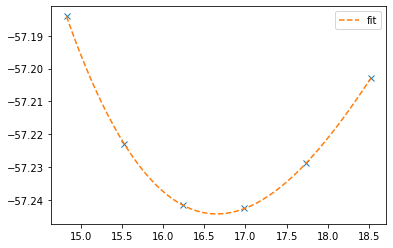

In [30]:
erg_fit = np.poly1d(np.polyfit(vol_lst, erg_lst, 3))
vol_fit = np.linspace(np.min(vol_lst), np.max(vol_lst), 100)
plt.plot(vol_lst, erg_lst, 'x')
plt.plot(vol_fit, erg_fit(vol_fit), '--', label='fit')
plt.legend();

### Using pandas for analysis

An alternate way to analyze these notebooks (if you are not a fan of for loops)

In [31]:
df = pr.job_table()

In [32]:
df = df[df.status=="finished"]
df;

In [33]:
%%time
df_result = df.apply(get_properties, axis=1)
df_result[["a", "e_tot", "encut", "kpoints", "n_scf"]]

CPU times: user 128 ms, sys: 7.98 ms, total: 136 ms
Wall time: 367 ms


,a,e_tot,encut,kpoints,n_scf
0,3.90,-57.184040,350,"[12, 12, 12]",4
1,3.96,-57.222944,350,"[12, 12, 12]",4
2,4.02,-57.241557,350,"[12, 12, 12]",3
3,4.08,-57.242664,350,"[12, 12, 12]",4
4,4.14,-57.228889,350,"[12, 12, 12]",4
5,4.20,-57.202822,350,"[12, 12, 12]",4


## Use the murnaghan module to scan over different k-points and energy cutoff values as in ex_2


In [34]:
pr = Project("demo/murnaghan_dft")
###pr.remove_jobs()

In [35]:
encut_list = [250, 350, 450]
#kpoint_list = [4, 8, 12, 16]
kpoint_list = [4, 12]

for kpt in kpoint_list:
    for encut in encut_list:
        job_name = "murn_Al_encut_{}_kpt_{}".format(encut, kpt)
        murn = pr.create_job(pr.job_type.Murnaghan, job_name)
        job_ref = pr.create_job(pr.job_type.Sphinx, "Al_ref")
        job_ref.structure = pr.create_ase_bulk("Al")
        job_ref.calc_static()
        job_ref.plane_wave_cutoff = encut
        k_mesh = [kpt] * 3
        job_ref.set_kpoints(mesh=k_mesh)
        murn.ref_job = job_ref
        murn.input["num_points"] = 9
        murn.run()

The job murn_Al_encut_250_kpt_4 was saved and received the ID: 255
job.input.structure != job.structure. The current job.structure will overwrite any changes you may might have made to job.input.structure in the meantime. To disable this overwrite, set job.input.structure.read_only = True. To disable this warning, call job.load_structure_group() after making changes to job.structure.
The job strain_0_9 was saved and received the ID: 256
job.input.structure != job.structure. The current job.structure will overwrite any changes you may might have made to job.input.structure in the meantime. To disable this overwrite, set job.input.structure.read_only = True. To disable this warning, call job.load_structure_group() after making changes to job.structure.
The job strain_0_925 was saved and received the ID: 260
job.input.structure != job.structure. The current job.structure will overwrite any changes you may might have made to job.input.structure in the meantime. To disable this overwrite, s

The job strain_0_925 was saved and received the ID: 326
job.input.structure != job.structure. The current job.structure will overwrite any changes you may might have made to job.input.structure in the meantime. To disable this overwrite, set job.input.structure.read_only = True. To disable this warning, call job.load_structure_group() after making changes to job.structure.
The job strain_0_95 was saved and received the ID: 329
job.input.structure != job.structure. The current job.structure will overwrite any changes you may might have made to job.input.structure in the meantime. To disable this overwrite, set job.input.structure.read_only = True. To disable this warning, call job.load_structure_group() after making changes to job.structure.
The job strain_0_975 was saved and received the ID: 332
job.input.structure != job.structure. The current job.structure will overwrite any changes you may might have made to job.input.structure in the meantime. To disable this overwrite, set job.inp

job.input.structure != job.structure. The current job.structure will overwrite any changes you may might have made to job.input.structure in the meantime. To disable this overwrite, set job.input.structure.read_only = True. To disable this warning, call job.load_structure_group() after making changes to job.structure.
The job strain_1_0 was saved and received the ID: 381
job.input.structure != job.structure. The current job.structure will overwrite any changes you may might have made to job.input.structure in the meantime. To disable this overwrite, set job.input.structure.read_only = True. To disable this warning, call job.load_structure_group() after making changes to job.structure.
The job strain_1_025 was saved and received the ID: 382
job.input.structure != job.structure. The current job.structure will overwrite any changes you may might have made to job.input.structure in the meantime. To disable this overwrite, set job.input.structure.read_only = True. To disable this warning, c

### Using pyiron tables

In [36]:
from pyiron.table.datamining import PyironTable

In [37]:
pt = PyironTable(pr, "murn_table_dft")

In [38]:
murn["output/structure/cell/cell"][0, 1] * 2

4.052850088952362

In [39]:
def get_lattice_parameter(job):
    return job["output/structure/cell/cell"][0, 1] * 2

def get_eq_energy(job):
    return job["output/equilibrium_energy"]

def get_bm(job):
    return job["output/equilibrium_bulk_modulus"]

def get_encut(job):
    return get_encut_kpoints(job)[0]

def get_kpoints(job):
    return get_encut_kpoints(job)[1]

def get_cohesive_energy(job):
    e_bulk = get_eq_energy(job)
    encut_str= get_encut(job)
    encut = int(encut_str)
    atom_job_name = "aj_encut_{}".format(encut_str)
    df = pr.job_table()
    if not atom_job_name in df[df.status=="finished"].job.to_list():
        atom_job = pr.create_job(pr.job_type.Sphinx, atom_job_name)
        el = job["output/structure/species"][0]
        atom_job.structure = pr.create_atoms(el, cell=np.eye(3)* 10, scaled_positions=[[0.5, 0.5, 0.5]])
        atom_job.plane_wave_cutoff = encut
        # Using only the Gamma point
        atom_job.set_kpoints(mesh=[1, 1, 1])
        atom_job.calc_static()
        atom_job.run()
    e_atom = pr.inspect(atom_job_name)["output/generic/energy_tot"][-1]
    return e_bulk - e_atom

In [40]:
def filter_function(job):
    return (job.status == "finished") & ("murn" in job.job_name)

In [41]:
pt.filter_function = filter_function

In [42]:
pt.add["a_eq"] = get_lattice_parameter
pt.add["bulk_modulus"] = get_bm
pt.add["encut"] = get_encut
pt.add["kpoints"] = get_kpoints
pt.add["e_coh"] = get_cohesive_energy

In [43]:
pt.convert_to_object = False

In [44]:
pt.create_table()

  0%|          | 0/6 [00:00<?, ?it/s]

The job aj_encut_250 was saved and received the ID: 396


 17%|█▋        | 1/6 [00:12<01:01, 12.32s/it]

The job aj_encut_350 was saved and received the ID: 397


 33%|███▎      | 2/6 [00:30<00:55, 13.98s/it]

The job aj_encut_450 was saved and received the ID: 398


100%|██████████| 6/6 [00:53<00:00,  8.96s/it]


In [45]:
df = pt.get_dataframe().drop(["col_0", "col_1", "col_2"], axis=1)

In [46]:
df

,job_id,a_eq,bulk_modulus,encut,kpoints,e_coh
0,255,4.062126,81.203234,250,"[4, 4, 4]",-3.612128
1,288,4.057718,82.415304,350,"[4, 4, 4]",-3.621299
2,322,4.056997,81.890404,450,"[4, 4, 4]",-3.623744
3,352,4.058432,78.725017,250,"[12, 12, 12]",-3.667680
4,376,4.053631,79.844466,350,"[12, 12, 12]",-3.676872
5,386,4.052850,79.383996,450,"[12, 12, 12]",-3.679358
